In [ ]:
!pip install PyTDC

In [ ]:
!git clone https://github.com/chemprop/chemprop

In [1]:
!pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 12.1 MB/s eta 0:00:00


In [2]:
!pip install mendeleev
import mendeleev

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.3/353.3 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.8/865.8 kB 69.0 MB/s eta 0:00:00


In [3]:
!pip install chemprop
#!pip install rdkit-pypi  # should be included in above after Chemprop v1.6 release

# # Download test files from GitHub
# !apt install subversion
# !svn export https://github.com/chemprop/chemprop.git/trunk/tests/data

import chemprop
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.6/166.6 kB 12.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for chemprop: filename=chemprop-1.5.2-py3-none-any.whl size=149134 sha256=295a9a1242a7a6a5f4ff5b99c05aca9cfac2b22c874955c3537dcd8ca55f140a
  Stored in directory: /root/.cache/pip/wheels/20/1f/ee/62fe93d2c7c23c674af59f31cf2ea83c9c49f61c0a613ac842
  Created wheel for typed-argument-parser: filename=typed_argument_parser-1.8.0-py3-none-any.whl size=25458 sha256=d6f41733855cc08b832e7a5b2230efb757247b876473ec9deab586dc1810ca6b
  Stored in directory: /root/.cache/pip/wheels/ed/39/c5/b470e80aba24fdd11df9c33de12094085a8cb8b30ee10f970a
Successfully built chemprop 

In [4]:
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import sys
import torch 
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt

from rdkit import RDLogger   
RDLogger.DisableLog('rdApp.*') # turn off RDKit warning message 

In [5]:
prsm = pd.read_csv('./Prism_fixed.csv')

In [7]:
# Create physical features 
smiles = prsm['SMILES']

atom_numbers = [*range(1,100)]
envs_list = np.array([0]+[mendeleev.element(i).en_pauling for i in atom_numbers])
radii_list = np.array([0]+[mendeleev.element(i).atomic_radius for i in atom_numbers])
polar_list = np.array([0]+[mendeleev.element(i).dipole_polarizability for i in atom_numbers])
elaff_list = np.array([0]+[mendeleev.element(i).electron_affinity for i in atom_numbers])
ionen_list = np.array([0]+[mendeleev.element(i).ionenergies[1] for i in atom_numbers])

for i in range(len(envs_list)):
  if envs_list[i] is None:
    envs_list[i] = 0

for i in range(len(radii_list)):
  if radii_list[i] is None:
    radii_list[i] = 0

for i in range(len(polar_list)):
  if polar_list[i] is None:
    polar_list[i] = 0

for i in range(len(elaff_list)):
  if elaff_list[i] is None:
    elaff_list[i] = 0

for i in range(len(ionen_list)):
  if ionen_list[i] is None:
    ionen_list[i] = 0

radii = []
envs = []
polar = []
elaff = []
ionen = []
for SMILES in smiles:

  mol = Chem.MolFromSmiles(SMILES)
  atoms = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
  radii.append([radii_list[i] for i in atoms])
  envs.append([envs_list[i] for i in atoms])
  polar.append([polar_list[i] for i in atoms])
  elaff.append([elaff_list[i] for i in atoms])
  ionen.append([ionen_list[i] for i in atoms])

ar = []
for r,e,p,el,io in zip(radii, envs, polar, elaff, ionen):
  ar.append(np.vstack([np.array(r), np.array(e), np.array(p), np.array(el), np.array(io)]).T)


In [8]:
# Create functional group features.
def get_indices_of_functional_groups(mol, smarts_pattern):
    """
    Returns the indices of atoms in a molecule that match a specified functional group pattern.
    If there are multiple matches, all the matches are returned as individual lists.

    :param mol: A molecule.
    :param smarts_pattern: A SMARTS pattern.
    :return: A nested list of atom indices, where each inner list corresponds to a single match.
    """
    
    pattern = Chem.MolFromSmarts(smarts_pattern)
    # find all matches to the pattern.
    occurance_list = []
    for i, match in enumerate(mol.GetSubstructMatches(pattern)):
        indices = []
        for j in match:
            mol.GetAtomWithIdx(j).SetProp('feature', str(i + 1))
            indices.append(j)
        occurance_list.append(indices)
    return occurance_list

# How to run the function above.
# print(get_indices_of_functional_groups(Chem.MolFromSmiles('CC(CS)C(=O)N1CCCC1C(=O)O'), '[CX3]=[OX1]'))

# Read in tab separated file of smarts patterns and functional group names
fg = pd.read_csv('./SMARTS_functional_groups_debug.txt', sep='\t')

# Make a hash table of the reactivity. 
reactivity_dict = {}
for i, row in fg.iterrows():
    reactivity_dict[row['Description']] = row['REACTIVITY']
# Also make a hash table of the H_RELEVANT column.
h_relevant_dict = {}
for i, row in fg.iterrows():
    h_relevant_dict[row['Description']] = row['H_RELEVANT']

functional_groups_feature_all = []
reactivity_feature_all = []
h_relevant_feature_all = []

for SMILES in smiles:
    mol = Chem.MolFromSmiles(SMILES)
    atoms = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    num_atoms = len(atoms)
    # Create a list of the atom indices that match the SMARTS pattern and 0's for the rest.
    
    all_functional_groups = []
    all_reactivity = []
    all_h_relevant = []

    for i, row in fg.iterrows():
        SMARTS = row['SMARTS']
        functional_group = np.zeros(num_atoms)
        reactivity = np.zeros(num_atoms)
        h_relevant = np.zeros(num_atoms)

        # Get the indices of atoms that match the SMARTS pattern.
        indices = get_indices_of_functional_groups(mol, SMARTS)
        
        for j, index_list in enumerate(indices):
            for atom in index_list:
                functional_group[atom] = j + 1
                reactivity[atom] = reactivity_dict[row['Description']]
                h_relevant[atom] = h_relevant_dict[row['Description']]

        # if len(indices) > 0:
        #     print(row['Description'])
        #     print(functional_group)
        #     display(mol)

        all_functional_groups.append(functional_group)
        all_reactivity.append(reactivity)
        all_h_relevant.append(h_relevant)
    
    all_functional_groups = np.vstack(all_functional_groups).T
    functional_groups_feature_all.append(all_functional_groups)
    all_reactivity = np.vstack(all_reactivity).T
    reactivity_feature_all.append(all_reactivity)
    all_h_relevant = np.vstack(all_h_relevant).T
    h_relevant_feature_all.append(all_h_relevant)
# Save the data
np.savez('feature_physical_description.npz', *ar)
np.savez('feature_functional_group.npz', *functional_groups_feature_all)
np.savez('feature_h_relevant.npz', *h_relevant_feature_all)
np.savez('feature_reactivity.npz', *reactivity_feature_all)

In [9]:
all = ar + functional_groups_feature_all + reactivity_feature_all + h_relevant_feature_all 
np.savez('all.npz', *all)

In [ ]:
!chemprop_train --data_path 'Prism_fixed.csv' --dataset_type 'regression' \
 --smiles_column 'SMILES' --target_columns 'Y' --save_dir './' --atom_descriptors feature --atom_descriptors_path './feature_physical_description.npz' \
 --overwrite_default_atom_features

Command line
python /usr/local/bin/chemprop_train --data_path Prism_fixed.csv --dataset_type regression --smiles_column SMILES --target_columns Y --save_dir ./ --atom_descriptors feature --atom_descriptors_path ./feature_physical_description.npz --overwrite_default_atom_features
Args
{'activation': 'ReLU',
 'adding_bond_types': True,
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_constraints': [],
 'atom_descriptor_scaling': True,
 'atom_descriptors': 'feature',
 'atom_descriptors_path': './feature_physical_description.npz',
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'atom_targets': [],
 'batch_size': 50,
 'bias': False,
 'bias_solvent': False,
 'bond_constraints': [],
 'bond_descriptor_scaling': True,
 'bond_descriptors': None,
 'bond_descriptors_path': None,
 'bond_descriptors_size': 0,
 'bond_features_size': 0,
 'bond_targets': [],
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoi

In [ ]:
!chemprop_train --data_path 'Prism_fixed.csv' --dataset_type 'regression' \
 --smiles_column 'SMILES' --target_columns 'Y' --save_dir './' --atom_descriptors feature --atom_descriptors_path './feature_functional_group.npz' \
 --overwrite_default_atom_features

Command line
python /usr/local/bin/chemprop_train --data_path Prism_fixed.csv --dataset_type regression --smiles_column SMILES --target_columns Y --save_dir ./ --atom_descriptors feature --atom_descriptors_path ./feature_functional_group.npz --overwrite_default_atom_features
Args
{'activation': 'ReLU',
 'adding_bond_types': True,
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_constraints': [],
 'atom_descriptor_scaling': True,
 'atom_descriptors': 'feature',
 'atom_descriptors_path': './feature_functional_group.npz',
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'atom_targets': [],
 'batch_size': 50,
 'bias': False,
 'bias_solvent': False,
 'bond_constraints': [],
 'bond_descriptor_scaling': True,
 'bond_descriptors': None,
 'bond_descriptors_path': None,
 'bond_descriptors_size': 0,
 'bond_features_size': 0,
 'bond_targets': [],
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path'

In [ ]:
!chemprop_train --data_path 'Prism_fixed.csv' --dataset_type 'regression' \
 --smiles_column 'SMILES' --target_columns 'Y' --save_dir './' --atom_descriptors feature --atom_descriptors_path './feature_h_relevant.npz' \
 --overwrite_default_atom_features

Command line
python /usr/local/bin/chemprop_train --data_path Prism_fixed.csv --dataset_type regression --smiles_column SMILES --target_columns Y --save_dir ./ --atom_descriptors feature --atom_descriptors_path ./feature_h_relevant.npz --overwrite_default_atom_features
Args
{'activation': 'ReLU',
 'adding_bond_types': True,
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_constraints': [],
 'atom_descriptor_scaling': True,
 'atom_descriptors': 'feature',
 'atom_descriptors_path': './feature_h_relevant.npz',
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'atom_targets': [],
 'batch_size': 50,
 'bias': False,
 'bias_solvent': False,
 'bond_constraints': [],
 'bond_descriptor_scaling': True,
 'bond_descriptors': None,
 'bond_descriptors_path': None,
 'bond_descriptors_size': 0,
 'bond_features_size': 0,
 'bond_targets': [],
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'ch

In [ ]:
!chemprop_train --data_path 'Prism_fixed.csv' --dataset_type 'regression' \
 --smiles_column 'SMILES' --target_columns 'Y' --save_dir './' --atom_descriptors feature --atom_descriptors_path './feature_reactivity.npz' \
 --overwrite_default_atom_features

Command line
python /usr/local/bin/chemprop_train --data_path Prism_fixed.csv --dataset_type regression --smiles_column SMILES --target_columns Y --save_dir ./ --atom_descriptors feature --atom_descriptors_path ./feature_reactivity.npz --overwrite_default_atom_features
Args
{'activation': 'ReLU',
 'adding_bond_types': True,
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_constraints': [],
 'atom_descriptor_scaling': True,
 'atom_descriptors': 'feature',
 'atom_descriptors_path': './feature_reactivity.npz',
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'atom_targets': [],
 'batch_size': 50,
 'bias': False,
 'bias_solvent': False,
 'bond_constraints': [],
 'bond_descriptor_scaling': True,
 'bond_descriptors': None,
 'bond_descriptors_path': None,
 'bond_descriptors_size': 0,
 'bond_features_size': 0,
 'bond_targets': [],
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'ch

In [ ]:
all = ar + functional_groups_feature_all + reactivity_feature_all + h_relevant_feature_all 
np.savez('all.npz', *all)

In [10]:
!chemprop_train --data_path 'Prism_fixed.csv' --dataset_type 'regression' \
 --smiles_column 'SMILES' --target_columns 'Y' --save_dir './' --atom_descriptors feature --atom_descriptors_path './all.npz' \
 --overwrite_default_atom_features

Command line
python /usr/local/bin/chemprop_train --data_path Prism_fixed.csv --dataset_type regression --smiles_column SMILES --target_columns Y --save_dir ./ --atom_descriptors feature --atom_descriptors_path ./all.npz --overwrite_default_atom_features
Args
{'activation': 'ReLU',
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_descriptor_scaling': True,
 'atom_descriptors': 'feature',
 'atom_descriptors_path': './all.npz',
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'batch_size': 50,
 'bias': False,
 'bias_solvent': False,
 'bond_feature_scaling': True,
 'bond_features_path': None,
 'bond_features_size': 0,
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'class_balance': False,
 'config_path': None,
 'crossval_index_dir': None,
 'crossval_index_file': None,
 'crossval_index_sets': None,
 'cuda': True,
 'data_path': 'Prism_fixed.csv',
 'dat

In [ ]:
ground_truth = prsm['Y']

In [ ]:
!chemprop_predict --test_path './Prism_fixed.csv' --smiles_column 'SMILES' --checkpoint_dir './fold_0/model_0' --preds_path './PRISM_predicted.csv' --atom_descriptors feature --atom_descriptors_path './feature_reactivity.npz'


Loading training args
Setting molecule featurization parameters to default.
Loading data
4177it [00:00, 319916.87it/s]
100% 4177/4177 [00:00<00:00, 20686.82it/s]
Validating SMILES
Test size = 4,177
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0% 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W_

In [ ]:
!chemprop_train --data_path 'Prism_fixed.csv' --dataset_type 'regression' --smiles_column 'SMILES' --target_columns 'Y' --save_dir './'

Command line
python /usr/local/bin/chemprop_train --data_path Prism_fixed.csv --dataset_type regression --smiles_column SMILES --target_columns Y --save_dir ./
Args
{'activation': 'ReLU',
 'adding_bond_types': True,
 'adding_h': False,
 'aggregation': 'mean',
 'aggregation_norm': 100,
 'atom_constraints': [],
 'atom_descriptor_scaling': True,
 'atom_descriptors': None,
 'atom_descriptors_path': None,
 'atom_descriptors_size': 0,
 'atom_features_size': 0,
 'atom_messages': False,
 'atom_targets': [],
 'batch_size': 50,
 'bias': False,
 'bias_solvent': False,
 'bond_constraints': [],
 'bond_descriptor_scaling': True,
 'bond_descriptors': None,
 'bond_descriptors_path': None,
 'bond_descriptors_size': 0,
 'bond_features_size': 0,
 'bond_targets': [],
 'cache_cutoff': 10000,
 'checkpoint_dir': None,
 'checkpoint_frzn': None,
 'checkpoint_path': None,
 'checkpoint_paths': None,
 'class_balance': False,
 'config_path': None,
 'constraints_path': None,
 'crossval_index_dir': None,
 'crossval_

In [ ]:
!chemprop_predict --test_path './Prism_fixed.csv' --smiles_column 'SMILES' --checkpoint_dir './fold_0/model_0' --preds_path './PRISM_predicted.csv' 

Loading training args
Setting molecule featurization parameters to default.
Loading data
4177it [00:00, 312844.55it/s]
100% 4177/4177 [00:00<00:00, 176813.93it/s]
Validating SMILES
Test size = 4,177
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0% 0/1 [00:00<?, ?it/s]Loading pretrained parameter "encoder.encoder.0.cached_zero_vector".
Loading pretrained parameter "encoder.encoder.0.W_i.weight".
Loading pretrained parameter "encoder.encoder.0.W_h.weight".
Loading pretrained parameter "encoder.encoder.0.W_o.weight".
Loading pretrained parameter "encoder.encoder.0.W

In [ ]:
pred = pd.read_csv('./PRISM_predicted.csv')
predicted = pred['Y']

In [ ]:
pred['ground_truth'] = ground_truth

In [ ]:
pred.to_csv('./default_prediction.csv', index=False)

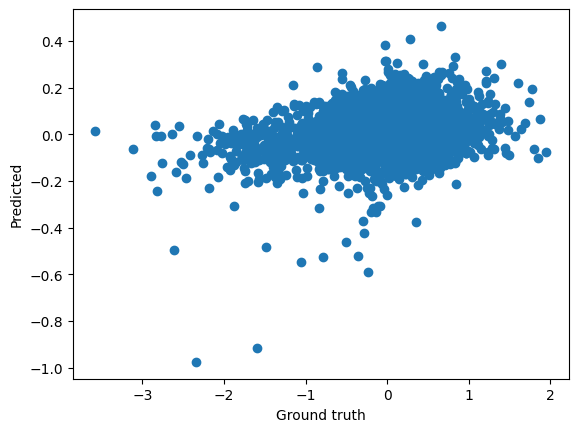

In [ ]:
plt.scatter(ground_truth, predicted)

# Add a label for the x-axis
plt.xlabel('Ground truth')

# Add a label for the y-axis
plt.ylabel('Predicted')

# Show the plot
plt.show()

In [22]:
top_10 = prsm.nsmallest(10, 'Y')

In [23]:
top_10['SMILES']

2608    COc1cc2[C@H]3CC[C@]4(C)[C@@H](O)CC[C@H]4[C@@H]...
3389     FC(F)(F)Oc1ccc(NC(=O)c2sccc2NCc2ccnc3ccccc23)cc1
3357    CC[C@@]1(O)C(=O)OCc2c1cc1-c3nc4ccc(O)cc4cc3Cn1...
2902    CC(C)[C@@H](N(CCCN)C(=O)c1ccc(C)cc1)c1oc2cc(Cl...
3268    OC[C@H]1O[C@@H](Oc2cc(O)cc(\C=C\c3ccc(O)cc3)c2...
2889      Nc1nc(Cl)nc2n(cnc12)[C@H]1C[C@H](O)[C@@H](CO)O1
1825    CSC1SCC2N(C)C(=O)C(C)NC(=O)C(COC(=O)C(C(C)C)N(...
3069    CN(C)C[C@@H](NC(=O)N1Cc2c(Nc3nc(C)nc4ccsc34)n[...
2654                   COc1cc2ncnc(Nc3ccc(Cl)cc3F)c2cc1OC
925                      Nc1nnc(Sc2ncc(s2)[N+]([O-])=O)s1
Name: SMILES, dtype: object

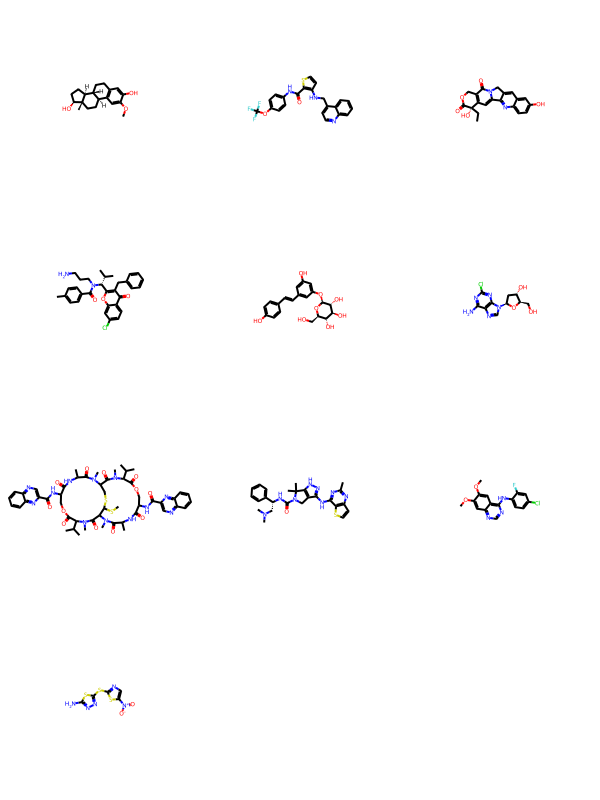

In [24]:
mols = []
for i in top_10['SMILES']:
  mols.append(Chem.MolFromSmiles(i))
Draw.MolsToGridImage(mols)

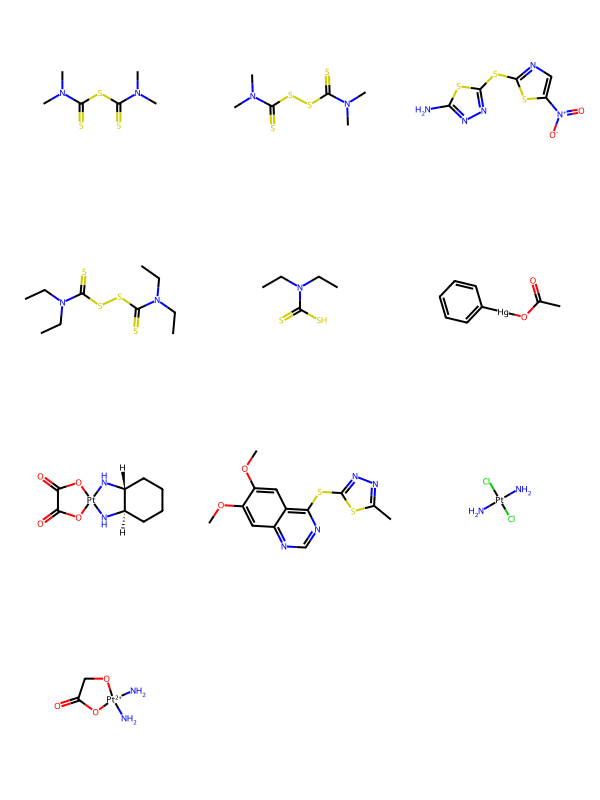

In [25]:
pred = pd.read_csv('./all_features_prediction.csv')
top_10 = pred.nsmallest(10, 'Y')
mols = []
for i in top_10['SMILES']:
  mols.append(Chem.MolFromSmiles(i))
Draw.MolsToGridImage(mols)